# Imputation algorithm reccomendation pipeline

The pipeline will take a dataset and preprocess the data, extracting the metafeatures as input into the machine learning model. As mentioned, this data will then be run through the multi-classification network which will output an imputation algorithm recommendation for replacing the missing data in the dataset. The main purpose of this pipeline is to make the recommendation model more usable by creating a functional proccess that can return a prediction from the model with the only user input being a dataset file (JSON or csv file)

<br>
<br>

As mentioned before large parts of this pipeline will be taken from other files (specifically other python notebook files) This files is simply a place where all of these individual larger elements can be merged together. Furthermore performing testing on the machine learning model in the same place as it is used in the pipeline would be messy. In the next few sections we set up each section of the pipeline into its own invidual function for the sake of code and section separability, each of these functions are compile into the overall pipeline at the end.

<br>

#### The pipeline will contain five distinct sections:
1.   #### Input (target database)
2.   #### Dataset preprocessing and cleaning
3.   #### Dataset metafeatures extraction
4.   #### Imputation algorithm recommendation machine learning model
5.   #### Output (Imputation algorithm reccomendation)

<br>
<br>


#Mounting the Google drive

This allows us to access all the data we store in this project as well at the file system

In [ ]:
# Need to mount drive to access and save files that store model stats, figures, etc
from google.colab import drive
import os


# Mount the drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Final_year_project") # Path of reference for imports
folder = os.path.join("/content/drive/MyDrive/Final_year_project") # Reference for future use when importing / exporting files

# View files in the current working directory
!ls

Mounted at /content/drive
data
datasets
getImputationModelsStats.ipynb
getMissingData.ipynb
imputationRecommendationModel.ipynb
imputationRecommendationModelRandomForest.ipynb
machine_learning_model
pipeline.ipynb
random_forest_machine_learning_model
root


# Imports and installs

This section import and/or installs all neccessary python libraries

In [ ]:
# pip installs
!pip install fancyimpute
!pip install MissForest
!pip install scikit-learn numpy pandas
!pip install miceforest


# Imports
from fancyimpute import IterativeImputer
from fancyimpute import KNN
from missforest import MissForest
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tkinter import filedialog
import tkinter as tk
import miceforest as miceforest
import os
import gc
import zipfile
import pandas as pd
import shutil
import random
import numpy as np
import time
import json
import joblib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=171e2cd43d5dbd8660e4c9c72fa2dee34695fafc213f588f9c8c09a342cf9c09
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=75158b7148c3afdaa554ff39f095d9d1077b4a129fd5cac27b2a1da5fd995497
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.8 MB/s eta 0:00:00


# Pipeline section 1 - Input (target database)

In this section we take user input in the form of a file. This section of the pipeline will eventually evolve into a visual section in the user interface, instead here there will be a pop-up that simply gets the user to select a file from the users machines file explorer

In [ ]:
def get_file(file_path) -> pd.DataFrame:
    file_name = os.path.basename(file_path)


    # Check that a file is given
    if not file_path:


        raise ValueError("No file selected")


    # Check file path exists
    if not os.path.exists(file_path):


        raise ValueError(f"Given file: {file_name}, does not exist")


    # Make sure file is .json or .csv
    if not file_path.endswith(".json") and not file_path.endswith(".csv"):


        raise ValueError(f"Given file: {file_name}, file must be a .json or .csv file")


    # Open file into
    df = None


    if file_path.endswith(".json")


        # Load the entire JSON file content, handling line breaks and spaces
        with open(file_path, 'r') as f:
            # Read the entire file content as a string
            json_string = f.read()


            # Try to decode the entire string as a single JSON object
            try:
                json_data = json.loads(json_string)

            except json.JSONDecodeError:
                # If decoding as a single object fails, assume it's a sequence of objects
                # and decode them one by one
                json_data = [json.loads(line) for line in json_string.splitlines() if line.strip()]


        # Assuming your JSON file is a list of dictionaries
        df = pd.DataFrame(json_data):

    else:
        df = pd.read_csv(file_path)


    # Check file is not empty
    # The .empty attribute is a property, not a function, so remove the parentheses
    if df.empty:


        raise ValueError(f"Given File: {file_name}, file is empty")


    return df

# Pipeline section 2 - Dataset preprocessing and cleaning

In this section we take the user inputted file from the previous input section of the pipeline. Here the file is cleaned (for example by removing any data points of mismatching data types from non-missing values columns or by removing any improper values such as inf from all columns) Data also needs to be cleaned by removing missing values from the non missingness columns as by this section the user should have chosen a missingness column they want the algorithm reccomendation for

In [ ]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:

    # Find missing column
    missingness_column = df.columns[df.isnull().any()].tolist()[0]

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()


    # Strip whitespace from string values in each cell
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].str.strip()


    # # Drop rows with all missing values
    # independant_columns = [col for col in df.columns if col != missingness_column]
    # df = df.dropna(subset=independant_columns, axis=0, how='all')


    # Replace any numeric values that arent real numbers
    for column in [column for column in df.columns if not column == missingness_column]:


        if pd.api.types.is_numeric_dtype(df[column]):
            df = df[np.isfinite(np.array(df[column]))]


    # Finally remove duplicate rows
    df = df.drop_duplicates()


    return df.reset_index(), missingness_column


# Pipeline section 3 - Dataset metafeatures extraction

In this section we take the dataset from the user inmputted section that has now been cleaned / preproccessed in the previous section and extract the metafeatures and relevant information from the dataset that will be used by the machine learning model in the subsequent section. The subsections of this section will explain the different types of metafeatures extracted that are separated into individual function

<br>

Types of metafeatures extracted:
1.   Statistical metafeatures
2.   Missingness meateaftures

<br>

In this paper the following table of metafeatures are computed on training datasets to allow for comparison between them to assess how similar they are. We use this table as reference when creating the Metafeature extraction  functionality, however not all of these metafeatures are implemented.


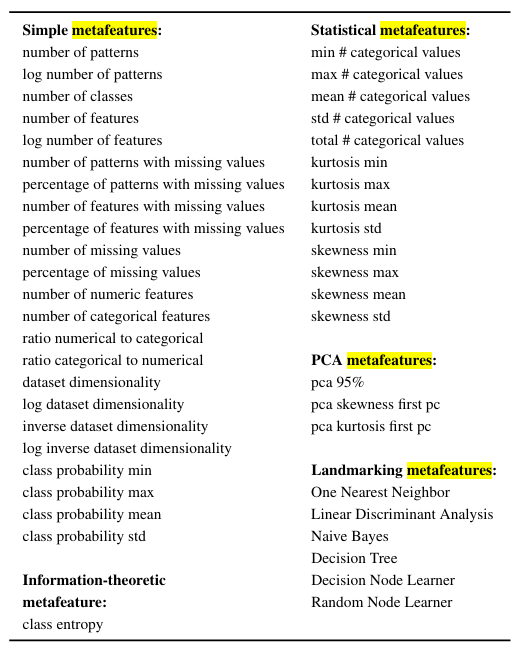

















Figure 1: Matthias Feurer and Jost Tobias Springenberg and Frank Hutte, 2014



#### Statistical metafeatures

This section contains functionality to extract the statical metafeatures from the cleaned / pre-proccessed dataset. These metafeatures are taken from a reference paper and contained in the following table

In [ ]:
def get_statistical_metafeatures(df: pd.DataFrame, missingness_column: str) -> dict[str, int]:
    """
    Return a dict of metafeatures under the typical 'simple' category
    """

    mf_simple = {}



    # Metafeatures not in the table

    # Number of Samples (rows)
    mf_simple["n_samples"] = float(len(df)) # Check this is best way of getting rows

    # Number of continuous features
    mf_simple["n_cols_continuous"]  = float(len(df.select_dtypes(include=["int64", "float64"]).columns))

    # Number of categorical features
    mf_simple["n_cols_categorical"] = float(len(df.select_dtypes(include=["object", "category"]).columns))

    # Log number of features over samples
    mf_simple["log_n_features_over_n_samples"] = float(np.log(len(df.columns)/len(df)))



    # Metafeature in the table

    # Number of patterns
    mf_simple["n_patterns"] = float(df.shape[0])

    # Log number of patterns
    mf_simple["log_n_patterns"] = float(np.log(df.shape[0]))

    # Number of Features (cols)
    mf_simple["n_features"] = float(df.shape[1])

    # Log number of features
    mf_simple["log_n_features"] = float(np.log(df.shape[1]))

    # Number of patterns with missing values
    mf_simple["n_patterns_with_missing"] = float(df.isna().any(axis=1).sum())

    # Percentage of patterns with missing values
    mf_simple["p_patterns_with_missing"] = float(df.isna().any(axis=1).sum() / df.shape[0] * 100)

    # Number of features with missing values
    mf_simple["n_features_with_missing"] = float(df.isna().any(axis=0).sum())

    # Percentage of features with missing values
    mf_simple["p_features_with_missing"] = float(df.isna().any(axis=0).sum() / df.shape[1] * 100)

    # Number of missing values
    mf_simple["n_missing_values"] = float(df.isna().sum().sum())

    # Percentage of missing values
    mf_simple["p_missing_values"] = float(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100)

    # Number of numeric features
    mf_simple["n_numeric_features"] = float(df.select_dtypes(include=["int64", "float64", "number"]).shape[1])

    # Number of categorical features
    mf_simple["n_categorical_features"] = float(df.select_dtypes(include=['object', 'category']).shape[1])

    # Ratio of numeric features to categorical features
    mf_simple["r_continuous_categorical"] = float(mf_simple["n_numeric_features"] / mf_simple["n_categorical_features"] if not mf_simple["n_categorical_features"] == 0 else mf_simple["n_numeric_features"])

    # Ratio of categorical features to numeric features
    mf_simple["n_categorical_continuous"] = float(mf_simple["n_categorical_features"] / mf_simple["n_numeric_features"] if not mf_simple["n_numeric_features"] == 0 else mf_simple["n_categorical_features"])

    # Dimensionality of the dataset
    mf_simple["d_dataset"] = float(sum(_ for _ in df.shape))

    # Log dimensionality of the dataset
    mf_simple["log_d_dataset"] = float(np.log(sum(_ for _ in df.shape)))

    # Inverse dimensionality of the dataset
    mf_simple["inv_d_dataset"] = float(1 / sum(_ for _ in df.shape))

    # Log inverse dimensionality of the dataset
    mf_simple["log_inv_d_dataset"] = float(np.log(1 / sum(_ for _ in df.shape)))

    # Get the average variance from numeircal columns
    mf_simple["variance"] = float(np.mean([df[column].var() for column in df.select_dtypes(include=["int64", "float64"]).columns]))

    # Get the average mean from numeircal columns
    mf_simple["mean"] = float(np.mean([df[column].mean() for column in df.select_dtypes(include=["int64", "float64"]).columns]))



    return mf_simple

#### Missingness metafeatures

This section contains functionality to extract the missingness metafeatures  from the cleaned / pre-proccessed dataset. These metafeatures include information about the missing data such as the proportion of missing data the missing data type, missing data mechansim, etc

In [ ]:
def get_missingness_metafeatures(df: pd.DataFrame, missingness_column, missingness_mechansim) -> dict[str, int]:
    """
    Return a dict of metafeatures
    """

    missingness_mechansim_map = {
        "MCAR": 0,
        "MAR": 1,
        "MNAR": 2
    }
    missingness_mechansim_map_inverse = {value: key for key, value in missingness_mechansim_map.items()}

    mf_missingness = {}


    # Create copy of the dataframe
    df_copy = df.copy()

    encoder = LabelEncoder()


    # Encode column if is categorical
    if not pd.api.types.is_numeric_dtype(df_copy[missingness_column]):
        df_copy[missingness_column] = encoder.fit_transform(df_copy[missingness_column])
        mf_missingness["is_numeric"] = float(0) #(False)

    else:
        mf_missingness["is_numeric"] = float(1) #(False)


    # Encode other columns if neccessary
    for column in df_copy.columns:


        if not pd.api.types.is_numeric_dtype(df_copy[column]) and not column == missingness_column:
            df_copy[column] = encoder.fit_transform(df_copy[column])


    # Get encoded missingness mechansim
    mf_missingness["missingness_mechansim"] = float(missingness_mechansim_map[missingness_mechansim.strip().upper()])




    # Metafeature extraction - General statistics

    # Mean of the missingness column
    # mf_missingness["mean"] = float(df_copy[missingness_column].mean())

    # # Variance of the missingness column
    # mf_missingness["variance"] = float(df_copy[missingness_column].var())

    # Median of the missingness column
    mf_missingness["median"] = float(df_copy[missingness_column].median())

    # Mode of the missingness column
    mf_missingness["mode"] = float(df_copy[missingness_column].mode().iloc[0])

    # Standard deviation of the missingness column
    mf_missingness["std"] = float(df_copy[missingness_column].std())

    # Minimum of the missingness column
    mf_missingness["min"] = float(df_copy[missingness_column].min())

    # Maximum of the missingness column
    mf_missingness["max"] = float(df_copy[missingness_column].max())

    # Range of the missingness column
    mf_missingness["range"] = float(df_copy[missingness_column].max() - df_copy[missingness_column].min())

    # Skewness of the missingness column
    mf_missingness["skewness"] = float(df_copy[missingness_column].skew())

    # Kurtosis of the missingness column
    mf_missingness["kurtosis"] = float(df_copy[missingness_column].kurt())

    # Interquartile range of the missingness column
    mf_missingness["iqr"] = float(df_copy[missingness_column].quantile(0.25) - df_copy[missingness_column].quantile(0.75))



    # Metafeature extraction - Data quality

    # Number of unqiue values in the missingness column
    mf_missingness["n_unique_values"] = float(df_copy[missingness_column].nunique())

    # Constant of the missingness column
    mf_missingness["constant"] = float(len(df[df_copy[missingness_column].isin([df_copy[missingness_column].mode()])]) / df_copy.shape[0])



    # Metafeature extraction - Entropy & Variability

    # Shannon entropy of the missingness dataset
    mf_missingness["shannon_entropy"] = float(-np.sum(df_copy.value_counts(normalize=True) * np.log2(df_copy.value_counts(normalize=True))))

    # Coefficient of variation of the missingness dataset
    mf_missingness["coefficient_of_variation"] = float(np.mean(df_copy.std()) / np.mean(df_copy.mean()))

    # Signal-to-noise ratio of variation of the missingness dataset
    mf_missingness["signal_to_noise_ration"] = float(np.mean(df_copy.mean()) / np.mean(df_copy.std()))



    # Metafeature extraction - Missingness stats

    # # Number of missing values in the missingness column
    # mf_missingness["n_missing_values"] = float(len(list(df_copy[missingness_column].isna())))

    # # Missingness ration of the missingness column
    # mf_missingness["p_missing_values"] = float(len(list(df_copy[missingness_column].isna())) / len(list(df_copy[missingness_column])) * 100)




    return mf_missingness

# Pipeline section 4 - Imputation algorithm recommendation machine learning model

In this section we take the metafeatures that have been extracted from the cleaned / pre-proccessed dataset inputted by the user and run them through the pre-trained multiclassification imputation reccomendation mechine learning model. This model has already be trained on the specific metafeatures extracted from the dataset to given a "reccomendation" of the optimal imputation algorithm to fill in the missing data points in the dataset the metafeatures were extracted from

In [ ]:
def model_recommendation(X_input, model_path, encoded_classess_path):
  # Load the saved model
  loaded_model = joblib.load(model_path)

  # Load the classess encoding
  encoded_classess_path = np.array(pd.read_csv(encoded_classess_path).columns)

  # Predict with loaded model
  y_pred = loaded_model.predict(X_input)


  return encoded_classess_path[y_pred][0]

# Pipeline - Manual pipline

In [ ]:
# Establish variables and paths
def manual_pipeline(file_path, model_path, missingness_mechansim, encoded_classess_path):

  # Part 1 - Dataset input
  df = get_file(file_path)



  # Part 2 - Dataset cleaning
  df, missingness_column = clean_data(df)



  # Part 3 - Metafeatures extraction# Get statistical metafeatures
  statistical_metafeatures = get_statistical_metafeatures(df, missingness_column)

  # Get missingness metafeaturews
  missingness_metafeatures = get_missingness_metafeatures(df, missingness_column, missingness_mechansim)

  # Get dataset metafeatures
  metafeatures = [list(statistical_metafeatures.values()) + list(missingness_metafeatures.values())]




  # Part 4 - Model prediction
  imputation_algorithm_recommendation = model_recommendation(metafeatures, model_path, encoded_classess_path)


  return imputation_algorithm_recommendation

# **Testing**

In this section we go through and test the code to validate the logic of the functionality and verify that it does exactly what we expect / want it to do. In the following sections we run the following types of tests on the code base:

1.   Manual functional testing

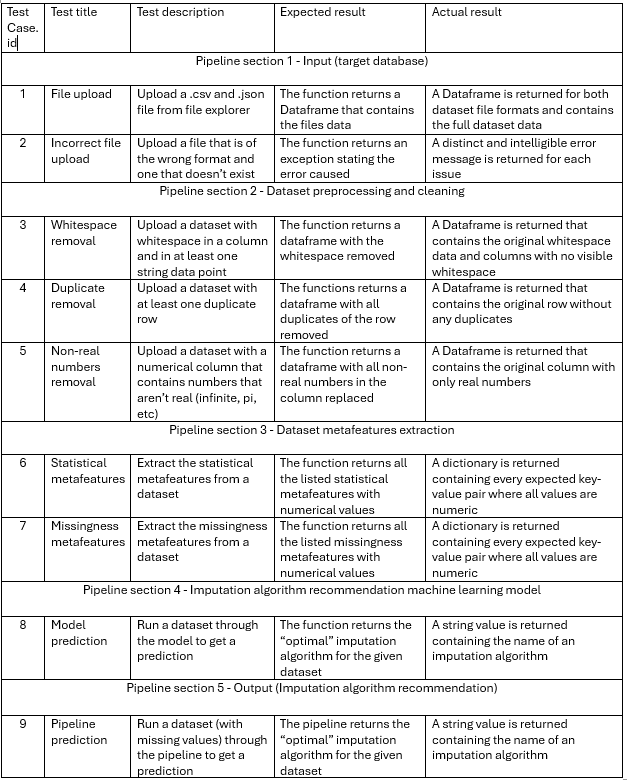

### Manual Functional Testing

Manual testing is executed to a specification (test case specification) which requires human intervention (manual execution by testers) without the use of any automation tools

<br>

### Test case specification:


#### Test 1 - File upload

Upload a .csv and .json file from file explorer. Assess that the function returns a Dataframe that contains the files data

In [ ]:
"""Initialise variables to run the test"""
file_path = "./data/MCAR/us-counties-2022.json"




"""Run the test"""
df = get_file(file_path)

# Assess that dataframe contains files data
print(df)

              date      county    state     fips  cases  deaths
0    1640995200000     Autauga  Alabama   1001.0  11018     160
1    1640995200000     Baldwin  Alabama   1003.0  39911     593
2    1640995200000     Barbour  Alabama   1005.0   3860      81
3    1640995200000        Bibb  Alabama   1007.0   4533      95
4    1640995200000      Blount  Alabama   1009.0  11256     198
..             ...         ...      ...      ...    ...     ...
995  1640995200000       Trego   Kansas  20195.0    560       9
996  1640995200000   Wabaunsee   Kansas  20197.0   1228      19
997  1640995200000     Wallace   Kansas  20199.0    346       5
998  1640995200000  Washington   Kansas      NaN   1016      18
999  1640995200000     Wichita   Kansas      NaN    350       8

[1000 rows x 6 columns]


#### Test 2 - Incorrect file upload

Upload a file that is of the wrong format and one that doesn’t exist. Assess that the function returns an exception stating the error caused

In [ ]:
"""Initialise variables to run the test"""
file_path = "./data/MCAR/us-counties-2029.json"




"""Run the test"""


try:
  df = get_file(file_path)

except Exception as e:

  # Assess that an error message is returned for the error you caused
  print(f"Error message: {e}")

Error message: Given file: us-counties-2029.json, does not exist


#### Test 3 - Whitespace removal

Upload a dataset with whitespace in a column and in at least one string data point. Assess that the function returns a dataframe with the whitespace removed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

# Show initial dataset
print(df)
print("")

# Add whitespace to column
columns = np.array(df.columns)
columns[0] = "  " + columns[0] + "   "
df.columns = columns

# Add whitespace to data-point
df["county"][0] = "  " + df["county"][0] + "   "

# Assess that the dataframe has been altered
print(df)
print("")




"""Run the test"""
df, _ = clean_data(df)

# Assess that the dataframe has been altered
print(df)
print("")

        date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65

     date           county    state    fips  cases  deaths
0 2022-01-01    Autauga     Alabama  1001.0  11018     160
1 2022-01-01       Baldwin  Alabama  1003.0  39911     593
2 2022-01-01       Barbour  Alabama  1005.0   3860      81
3 2022-01-01          Bibb  Alabama  1007.0   4533      95
4 2022-01-01        Blount  Alabama  1009.0  11256     198
5 2022-01-01       Bullock  Alabama     

<ipython-input-50-0bb9328e4247>:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["county"][0] = "  " + df["county"][0] + "   "
<ipython-input-50-0bb9328e4247>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Test 4 - Duplicate removal

Upload a dataset with at least one duplicate row. Assess that the function returns a dataframe with all duplicates of the row removed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

# Show initial dataset
print(df)
print("")

# Add duplicate row
selected_row = df.iloc[1: 2]
duplicated_row = pd.concat([selected_row for _ in range(0, 5)], ignore_index=True)

# Combine with original DataFrame
df = pd.concat([df, duplicated_row], ignore_index=True)

# Assess that the dataframe has been altered
print(df)
print("")




"""Run the test"""
df, _ = clean_data(df)

# Assess that the dataframe has been altered
print(df)
print("")

        date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65

         date    county    state    fips  cases  deaths
0  2022-01-01   Autauga  Alabama  1001.0  11018     160
1  2022-01-01   Baldwin  Alabama  1003.0  39911     593
2  2022-01-01   Barbour  Alabama  1005.0   3860      81
3  2022-01-01      Bibb  Alabama  1007.0   4533      95
4  2022-01-01    Blount  Alabama  1009.0  11256     198
5  2022-01-01   Bullock  Alabama     NaN   1676      46
6 

#### Test 5 - Non-real numbers removal

Upload a dataset with a numerical column that contains numbers that aren’t real (infinite, pi, etc). Assess that function returns a dataframe with all non-real numbers in the column replaced

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

# Show initial dataset
print(df)

# Insert non-real numbers into a numeric column
df["deaths"][0] = np.pi
df["deaths"][1] = np.inf
df["deaths"][2] = -np.inf

# Assess that the dataframe has been altered
print(df)




"""Run the test"""
df, _ = clean_data(df)

# Assess that the dataframe has been altered
print(df)

        date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65
        date    county    state    fips  cases      deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018    3.141593
1 2022-01-01   Baldwin  Alabama  1003.0  39911         inf
2 2022-01-01   Barbour  Alabama  1005.0   3860        -inf
3 2022-01-01      Bibb  Alabama  1007.0   4533   95.000000
4 2022-01-01    Blount  Alabama  1009.0  11256  198.000000
5 2022-01-01   Bullock  Alabama     NaN  

<ipython-input-52-1babc61d555f>:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["deaths"][0] = np.pi
<ipython-input-52-1babc61d555f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

#### Test 6 - Statistical metafeatures

Extract the statistical metafeatures from a dataset. Assess that the function returns all the listed statistical metafeatures with numerical values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)




"""Run the test"""
df, missingness_column = clean_data(df)
statistical_metafeatures = get_statistical_metafeatures(df, missingness_column)

# Assess that the metafeatures are valid
print(json.dumps(statistical_metafeatures, indent=4))

{
    "n_samples": 10.0,
    "n_cols_continuous": 4.0,
    "n_cols_categorical": 2.0,
    "log_n_features_over_n_samples": -0.35667494393873245,
    "n_patterns": 10.0,
    "log_n_patterns": 2.302585092994046,
    "n_features": 7.0,
    "log_n_features": 1.9459101490553132,
    "n_patterns_with_missing": 4.0,
    "p_patterns_with_missing": 40.0,
    "n_features_with_missing": 1.0,
    "p_features_with_missing": 14.285714285714285,
    "n_missing_values": 4.0,
    "p_missing_values": 5.714285714285714,
    "n_numeric_features": 4.0,
    "n_categorical_features": 2.0,
    "r_continuous_categorical": 2.0,
    "n_categorical_continuous": 0.5,
    "d_dataset": 17.0,
    "log_d_dataset": 2.833213344056216,
    "inv_d_dataset": 0.058823529411764705,
    "log_inv_d_dataset": -2.833213344056216,
    "variance": 36271352.1611111,
    "mean": 3024.0333333333333
}


#### Test 7 - Missingness metafeatures

Extract the missingness metafeatures from a dataset. Assess that the function returns all the listed missingness  metafeatures with numerical values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)




"""Run the test"""
df, missingness_column = clean_data(df)
missingness_metafeatures = get_missingness_metafeatures(df, missingness_column, "MCAR")

# Assess that the metafeatures are valid
print(json.dumps(missingness_metafeatures, indent=4))

{
    "is_numeric": 1.0,
    "missingness_mechansim": 0.0,
    "mean": 1006.3333333333334,
    "variance": 18.666666666666664,
    "median": 1006.0,
    "mode": 1001.0,
    "std": 4.320493798938573,
    "min": 1001.0,
    "max": 1013.0,
    "range": 12.0,
    "skewness": 0.4629100498862363,
    "kurtosis": -0.3000000000000371,
    "iqr": -5.0,
    "n_unique_values": 6.0,
    "constant": 0.0,
    "shannon_entropy": 2.584962500721156,
    "coefficient_of_variation": 1.0123379722612682,
    "signal_to_noise_ration": 0.9878123980337231,
    "n_missing_values": 10.0,
    "p_missing_values": 100.0
}


#### Test 8 - Model prediction

Run a dataset through the model to get a prediction. Assess that the function returns the “optimal” imputation algorithm for the given dataset

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
model_path = "/content/drive/MyDrive/Final_year_project/random_forest_machine_learning_model/experiement1_model/best_random_forest_model.pkl"
encoded_classess_path = "/content/drive/MyDrive/Final_year_project/random_forest_machine_learning_model/experiement1_model_stats/encoded_classess.csv"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)
print(df)




"""Run the test"""

# Clean dataset
df, missingness_column = clean_data(df)

# Get statistical metafeatures
statistical_metafeatures = get_statistical_metafeatures(df, missingness_column)

# Get missingness metafeaturews
missingness_metafeatures = get_missingness_metafeatures(df, missingness_column, "MCAR")

# Get dataset metafeatures
metafeatures = [list(statistical_metafeatures.values()) + list(missingness_metafeatures.values())]

# Get model reccomendation
imputation_algorithm_recommendation = model_recommendation(metafeatures, model_path, encoded_classess_path)

# Assess that the model reccomendation is valid
print(imputation_algorithm_recommendation)

        date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65
NOCF Imputation


#### Test 9 - Pipeline prediction

Run a dataset (with missing values) through the pipeline to get a prediction. Assess that the pipeline returns the “optimal” imputation algorithm for the given dataset

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
model_path = "/content/drive/MyDrive/Final_year_project/random_forest_machine_learning_model/experiement1_model/best_random_forest_model.pkl"
encoded_classess_path = "/content/drive/MyDrive/Final_year_project/random_forest_machine_learning_model/experiement1_model_stats/encoded_classess.csv"
file_path = "./data/MCAR/us-counties-2022.json"




"""Run the test"""

# Get model reccomendation
imputation_algorithm_recommendation = manual_pipeline(file_path, model_path, "MCAR", encoded_classess_path)

# Assess that the model reccomendation is valid
print(imputation_algorithm_recommendation)

NOCF Imputation
